## Import Libraries

In [10]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

# Load the Dataset

In [11]:
from keras.datasets import fashion_mnist
import numpy as np

(train_data, _), (_, _) = fashion_mnist.load_data()

# Rescales
x_train = train_data / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=3)

print(x_train.shape)

(60000, 28, 28, 1)


# Visualize the image matrix

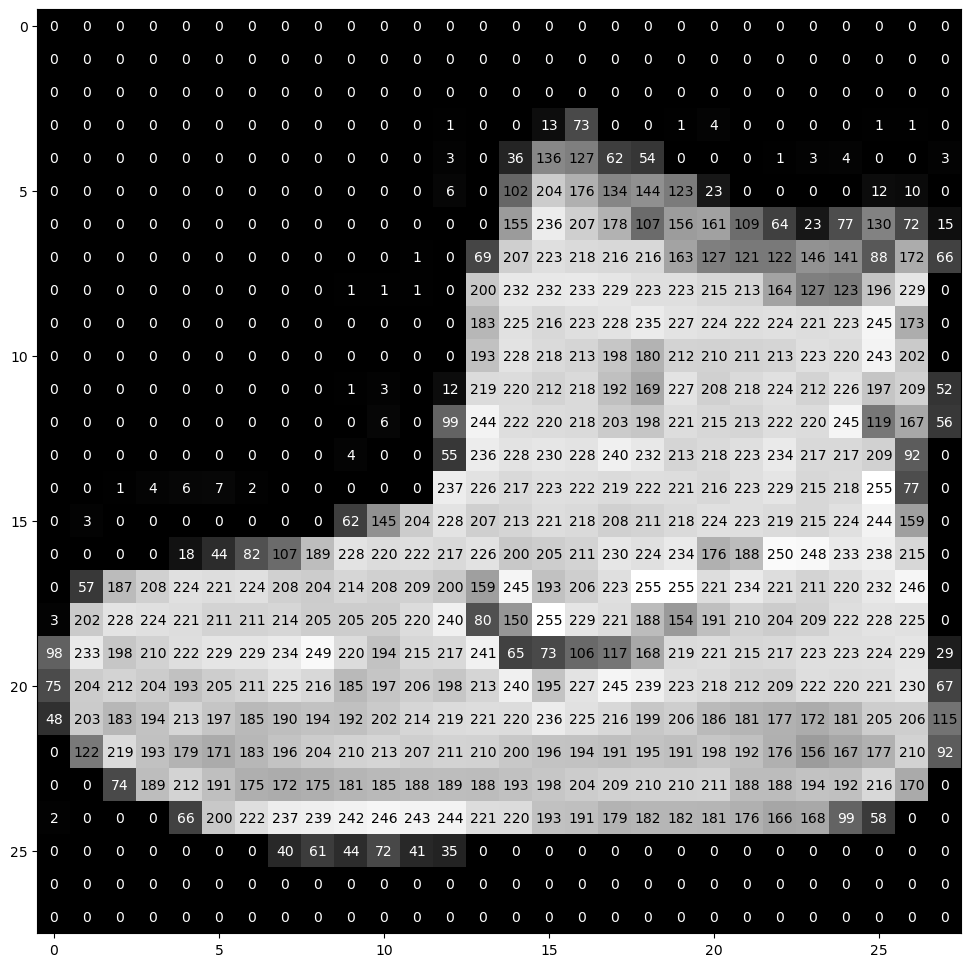

In [12]:
import matplotlib.pyplot as plt

def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    threshold = img.max() / 2.5
    
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)),
                        xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y] < threshold else 'black'
                        )
            
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(train_data[0], ax) # train_data[0] ~ train_data[59999]

# Build the generator

In [13]:
def build_generator(noise_shape=100):
    generator = Sequential()
    
    generator.add(
        Dense(128 * 7 * 7, activation = 'relu', input_dim=100)
    )
    
    generator.add(Reshape((7, 7, 128)))
    
    generator.add(UpSampling2D()) # 14 x 14
    
    generator.add(
        Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')
    )
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(UpSampling2D()) # 28 x 28
    
    generator.add(
        Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu')
    )
    generator.add(
        BatchNormalization(momentum=0.8)
    )
    
    generator.add(
        Conv2D(1, kernel_size = 3, padding = 'same', activation = 'tanh') # relu
    )
    
    print("Generator Model Built")
    generator.summary()
    
    noise= Input(shape=(noise_shape,)) # Generates the input noise vector of length = noise_shape
    
    fake_image = generator(noise)
    
    return Model(inputs=noise, outputs=fake_image)

# Build the discriminator

In [18]:
def build_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Input(shape=(28, 28, 1,)))
    
    discriminator.add(
        Conv2D(32, kernel_size=3, strides=2, padding = 'same')
    )
    
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(
        Conv2D(64, kernel_size=3, strides=2, padding = 'same')
    )
    
    discriminator.add(
        ZeroPadding2D(padding=((0, 1), (0, 1))) # 7 x 7 to 8 x 8
    )
    
    discriminator.add(
        BatchNormalization(momentum=0.8)
    )
    
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(
        Conv2D(128, kernel_size=3, strides=2, padding = 'same')
    )
    discriminator.add(
        BatchNormalization(momentum=0.8)
    )
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(
        Conv2D(256, kernel_size=3, strides=1, padding = 'same')
    )
    discriminator.add(
        BatchNormalization(momentum=0.8)
    )
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    print("Discriminator Model Built")
    discriminator.summary()
    
    img = Input(shape=(28, 28, 1,))
    proba = discriminator(img)
    
    return Model(inputs=img, outputs=proba)

# Build the Combined Model

In [19]:
from keras.optimizers import Adam, RMSprop

optimizer = Adam(
    learning_rate=0.0002,
    beta_1=0.5,
)
# optimizer = RMSprop(
#     learning_rate=0.0002,
#     rho=0.9,
#     centered=True
# )

discriminator = build_discriminator()
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

discriminator.trainable = False # Freezes the discriminator weights

noise_shape = 100
generator = build_generator(noise_shape)

z = Input(shape=(noise_shape,))
img = generator(z)

validity = discriminator(img)

combined = Model(inputs=z, outputs=validity)
combined.compile(
    loss='binary_crossentropy',
    optimizer=optimizer
)

Discriminator Model Built
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_14 (Bat  (None, 8, 8, 64)         256       
 chNormalization)           

# Build the train function

In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise_dim = 100  # This should be set according to the generator's input size
    noise = np.random.normal(0, 1, size=[examples, noise_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(
            generated_images[i],
            interpolation='nearest',
            cmap='gray_r'
        )
        plt.tight_layout()
    plt.savefig('GAN_generated_images_epoch_%d.png' % epoch)
    plt.close() # 메모리 사용량 증가 방지


def train(epochs, batch_size = 128, sample_interval=50):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size) # batch_size개의 정수를 생성하여 배열로 반환
        imgs = x_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100)) # size 매개변수에 전달된 tuple의 형태에 따라 임의의 숫자를 담은 다차원 배열이 반환
        gen_imgs = generator.predict(noise)
        
        # Trains the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Trains the generator
        g_loss = combined.train_on_batch(noise, valid)
        
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
        
        if epoch % sample_interval == 0:
            plot_generated_images(epoch, generator)

In [8]:
import tensorflow as tf
import logging
import os

# TensorFlow의 로그 수준을 설정합니다.
# 0 = 모든 메시지 출력 (디폴트값)
# 1 = info 메시지를 제외한 모든 메시지 출력
# 2 = warning 메시지를 제외한 모든 메시지 출력
# 3 = error 메시지를 제외한 모든 메시지 출력
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Python의 logging 모듈을 사용하여 특정 수준의 로그 메시지를 무시합니다.
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# 텐서플로우 런타임 설정 (에러 해결을 위한 설정)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

# 텐서플로우 세션을 명시적으로 초기화합니다.
tf.compat.v1.keras.backend.set_session(sess)

# 위노그라드 알고리즘 활성화
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

# Train and observe results

1/1 [==============================] - 0s 52ms/step
0 [D loss: 1.242914, acc.: 37.50%] [G loss: 0.661841]
1/1 [==============================] - 0s 15ms/step
1 [D loss: 0.572607, acc.: 70.31%] [G loss: 0.643007]
1/1 [==============================] - 0s 14ms/step
2 [D loss: 0.352513, acc.: 84.38%] [G loss: 0.676398]
1/1 [==============================] - 0s 15ms/step
3 [D loss: 0.167520, acc.: 96.88%] [G loss: 0.597548]
1/1 [==============================] - 0s 14ms/step
4 [D loss: 0.083495, acc.: 100.00%] [G loss: 0.608349]
1/1 [==============================] - 0s 14ms/step
5 [D loss: 0.099233, acc.: 96.88%] [G loss: 0.572932]
1/1 [==============================] - 0s 14ms/step
6 [D loss: 0.078088, acc.: 100.00%] [G loss: 0.472670]
1/1 [==============================] - 0s 14ms/step
7 [D loss: 0.064878, acc.: 100.00%] [G loss: 0.338710]
1/1 [==============================] - 0s 14ms/step
8 [D loss: 0.055965, acc.: 98.44%] [G loss: 0.312479]
1/1 [==============================] - 0s 1

KeyboardInterrupt: 

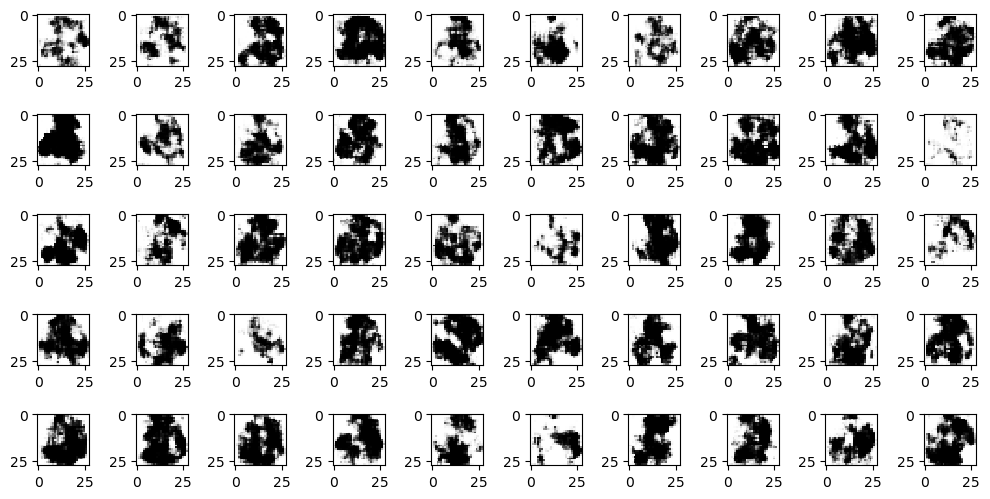

In [9]:
tf.config.set_visible_devices([], 'GPU')

train(epochs=200, batch_size=32, sample_interval=10)